# Task 2: Hyperelasticity



In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
import datetime
now = datetime.datetime.now

import importlib


### Data import

In [2]:
import numpy as np
data_biaxial = np.loadtxt('../../BCC/BCC_biaxial.txt')
data_shear = np.loadtxt('../../BCC/BCC_shear.txt')
data_planar = np.loadtxt('../../BCC/BCC_planar.txt')
data_test1 = np.loadtxt('../../BCC/BCC_test1.txt')
data_test2 = np.loadtxt('../../BCC/BCC_test2.txt')
data_test3 = np.loadtxt('../../BCC/BCC_test3.txt')

def process_data(data):

    F = data[:, :9].reshape(-1, 3, 3) 
    P = data[:, 9:18].reshape(-1, 3, 3)  
    SE = data[:, 18] 
    return F, P, SE


F_biaxial, P_biaxial, W_biaxial = process_data(data_biaxial)
F_shear, P_shear, W_shear = process_data(data_shear)
F_planar, P_planar, W_planar = process_data(data_planar)
F_test1, P_test1, W_test1 = process_data(data_test1)
F_test2, P_test2, W_test2 = process_data(data_test2)
F_test3, P_test3, W_test3 = process_data(data_test3)

In [3]:
def compute_invariants(F):
    F = tf.convert_to_tensor(F, dtype=tf.float32)
    batch_size = tf.shape(F)[0]
    
    # 计算右 Cauchy-Green 张量 C
    C = tf.einsum('bij,bjk->bik', tf.transpose(F, perm=[0, 2, 1]), F)
    
    # 计算不变量 I1, I2 和 J
    I1 = tf.linalg.trace(C)  # I1: Tr(C)
    Cof_C = tf.linalg.inv(C) * tf.linalg.det(C)[:, None, None]  # Cofactor matrix
    I2 = tf.linalg.trace(Cof_C)  # I2: Tr(Cof(C))
    J = tf.linalg.det(F)  # J: det(F)
    
    # 计算 G_cub 和不变量 I7
    e = tf.eye(3, dtype=tf.float32)  # 基础向量
    G_cub = tf.einsum('ij,kl->ijkl', e, e)  # 立方对称张量 G_cub
    G_cub = tf.tile(G_cub[None, :, :, :, :], [batch_size, 1, 1, 1, 1])  # 批量化
    I7 = tf.einsum('bij,bijkl,bkl->b', C, G_cub, C)  # I7: C : G_cub : C
    
    # 计算 I11
    I11 = tf.einsum('bij,bijkl,bkl->b', Cof_C, G_cub, Cof_C)  # I11: Cof(C) : G_cub : Cof(C)
    
    return I1, I2, J, I7, I11


In [4]:
I1_data_biaxial,I2_data_biaxial,J_data_biaxial,I7_data_biaxial,I11_data_biaxial = compute_invariants(F_biaxial)
I1_data_shear,I2_data_shear,J_data_shear,I7_data_shear,I11_data_shear = compute_invariants(F_shear)
I1_data_planar,I2_data_planar,J_data_planar,I7_data_planar,I11_data_planar = compute_invariants(F_planar)

In [5]:
I_train_biaxial = np.column_stack((I1_data_biaxial,I2_data_biaxial, J_data_biaxial, -J_data_biaxial, I7_data_biaxial, I11_data_biaxial))
I_train_shear = np.column_stack((I1_data_shear,I2_data_shear, J_data_shear, -J_data_shear, I7_data_shear, I11_data_shear))
I_train_planar = np.column_stack((I1_data_planar,I2_data_planar, J_data_planar, -J_data_planar, I7_data_planar, I11_data_planar))

In [6]:
F_train = np.concatenate([F_biaxial, F_shear, F_planar], axis=0)
P_train = np.concatenate([P_biaxial, P_shear, P_planar], axis=0)
I_train = np.concatenate([I_train_biaxial, I_train_shear, I_train_planar], axis=0)
W_train = np.concatenate([W_biaxial, W_shear, W_planar], axis=0)

In [21]:
def scale_data(P_train, W_train):
    # Step 1: 计算缩放因子 a
    # 这里使用 P_train 中所有分量的最大绝对值的倒数
    max_abs_P = np.max(np.abs(P_train))
    a = 1.0 / max_abs_P

    # Step 2: 应用缩放因子到应力张量和应变能
    P_train_scaled = a * P_train
    W_train_scaled = a * W_train

    return P_train_scaled, W_train_scaled, a

P_train_scaled, W_train_scaled, a = scale_data(P_train, W_train)
P_train_scaled = P_train_scaled.reshape(-1, 9)

In [22]:
P_train_tensor = tf.convert_to_tensor(P_train_scaled, dtype=tf.float32)
W_train_tensor = tf.convert_to_tensor(W_train_scaled, dtype=tf.float32)
I_train_tensor = tf.convert_to_tensor(I_train, dtype=tf.float32)

### Load ICNN model

In [9]:

import models_icnn as lm1

import importlib
importlib.reload(lm1)
model_icnn = lm1.main()

model_icnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 private_c_to_w (_C_to_W)    (None, 1)                 401       
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2500
13/13 [==============================] - 0s 2ms/step - loss: 366.1104
Epoch 2/2500
13/13 [==============================] - 0s 1ms/step - loss: 286.8074
Epoch 3/2500
13/13 [==============================] - 0s 1ms/step - loss: 210.4936
Epoch 4/2500
13/13 [==============================] - 0s 1ms/step - loss: 159.2685
Epoch 5/2500
13/13 [==============================] - 0s 1ms/step - loss: 124.3134
Epoch 6/2500
13/13 [==============================] - 0s 1ms/step - loss: 99.8130
Epoch 7/2500
13/13 [==============================] - 0s 1ms/step - loss: 82.0851
Epoch 8/2500
13/13 [==============================] - 0s 1ms/step - loss: 68.7415
Epoch 9/2500
13/13 [==============================] - 0s 1ms/step - loss: 58.7329
Epoch 10/2500
13/13 [==============================] - 0s 1ms/step - loss: 50.7311
Epoch 11/2500
13/13 [==============================] - 0s 1ms/step - loss: 44.2569
Epoch 12/2500
13/13 [==============================] - 0s 1ms/step - loss: 39.0172
Epoch 13

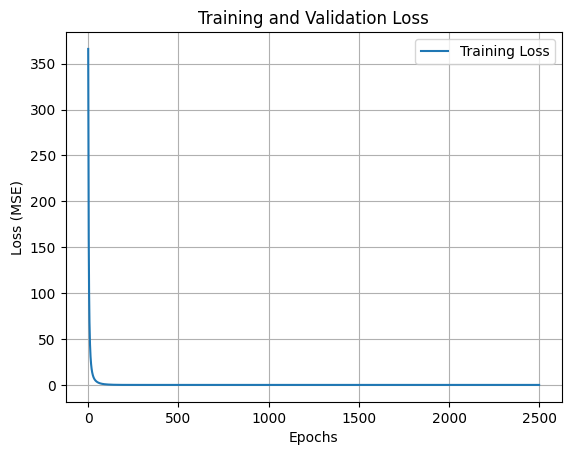

In [10]:
history = model_icnn.fit(I_train_tensor, W_train_tensor, epochs=2500)


import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()


In [11]:
def compute_stress_tensor(F,model):
    F = tf.convert_to_tensor(F, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(F)
        

        I1,I2, J, I7, I11 = compute_invariants(F)
        I_train = tf.stack([I1,I2, J, -J, I7, I11], axis=1)
        W_pred = model(I_train)

  
    P = tape.gradient(W_pred, F)
    
 
    #print("P:", P)
    
    return P

### Calibrate the model using both

In [12]:

optimizer = tf.optimizers.Adam(learning_rate=0.001)


def train_step(F, P_true, model):
    with tf.GradientTape(persistent=True) as tape:  
        tape.watch(F)
        
        
        I1,I2, J, I7, I11 = compute_invariants(F)
        I_train = tf.stack([I1,I2, J, -J, I7, I11], axis=1)
        W_pred = model(I_train)
        
        
        P_pred = tape.gradient(W_pred, F)
        
        
        loss_P = tf.reduce_mean(tf.square(P_pred - P_true))  
        loss = loss_P
    
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss

In [13]:
F_train_tensor = tf.convert_to_tensor(F_train, dtype=tf.float32)

In [14]:
for epoch in range(2500):
   
    loss = train_step(F_train_tensor, P_train_tensor, model_icnn)
    print(f"Epoch {epoch+1}, Loss: {loss.numpy()}")

Epoch 1, Loss: 0.008550171740353107
Epoch 2, Loss: 0.006101252045482397
Epoch 3, Loss: 0.004404538311064243
Epoch 4, Loss: 0.003356724977493286
Epoch 5, Loss: 0.0028664246201515198
Epoch 6, Loss: 0.002801839727908373
Epoch 7, Loss: 0.0029996028169989586
Epoch 8, Loss: 0.0032927701249718666
Epoch 9, Loss: 0.0035475967451930046
Epoch 10, Loss: 0.0036864348221570253
Epoch 11, Loss: 0.00368711119517684
Epoch 12, Loss: 0.0035647470504045486
Epoch 13, Loss: 0.0033577405847609043
Epoch 14, Loss: 0.003114132909104228
Epoch 15, Loss: 0.0028792608063668013
Epoch 16, Loss: 0.0026887364219874144
Epoch 17, Loss: 0.002564325463026762
Epoch 18, Loss: 0.002511650789529085
Epoch 19, Loss: 0.002520516514778137
Epoch 20, Loss: 0.00256832386367023
Epoch 21, Loss: 0.0026260579470545053
Epoch 22, Loss: 0.0026673278771340847
Epoch 23, Loss: 0.0026749796234071255
Epoch 24, Loss: 0.0026439691428095102
Epoch 25, Loss: 0.002580543514341116
Epoch 26, Loss: 0.0024985841009765863
Epoch 27, Loss: 0.00241458904929459

In [15]:
P_train_pred = compute_stress_tensor(F_train,model_icnn)/a
P_test_pred = compute_stress_tensor(F_test1,model_icnn)/a

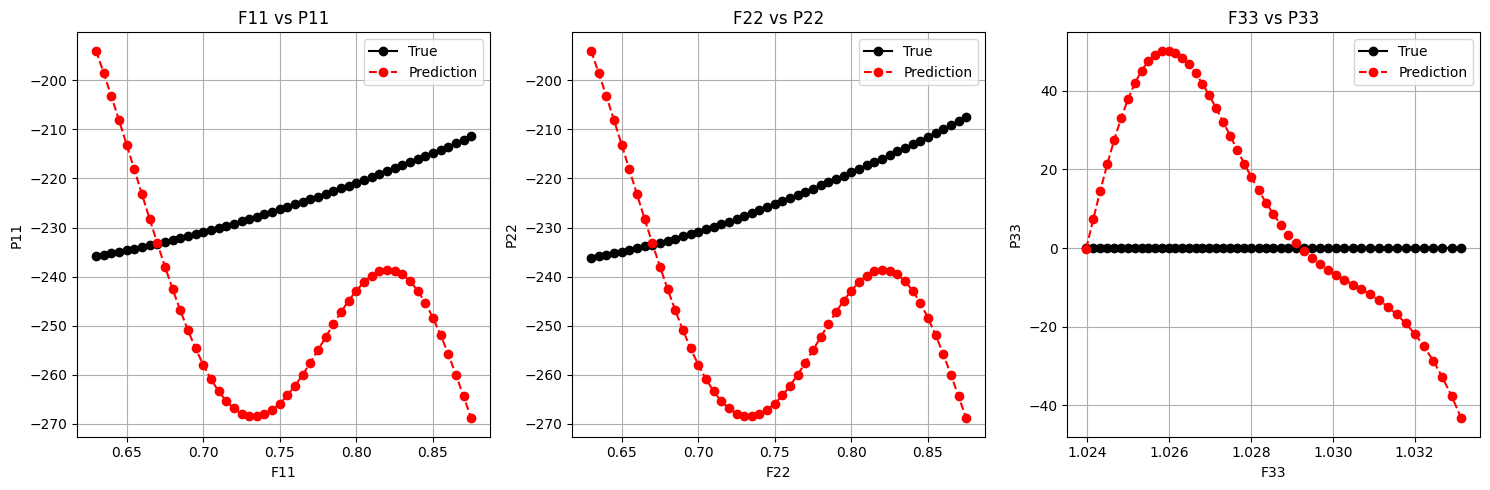

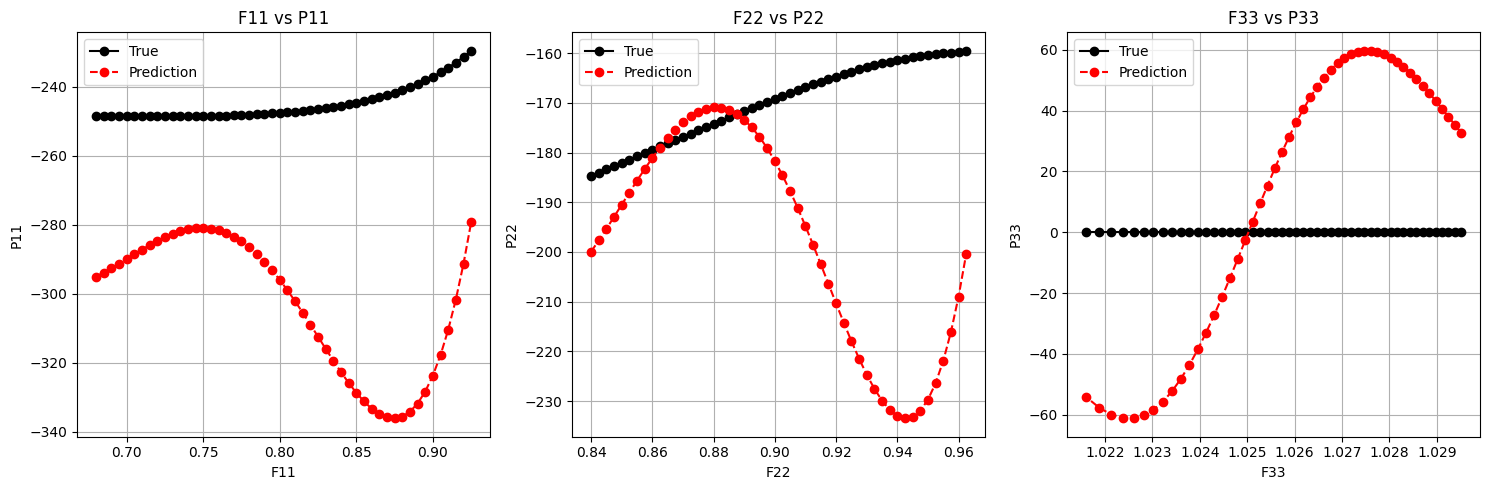

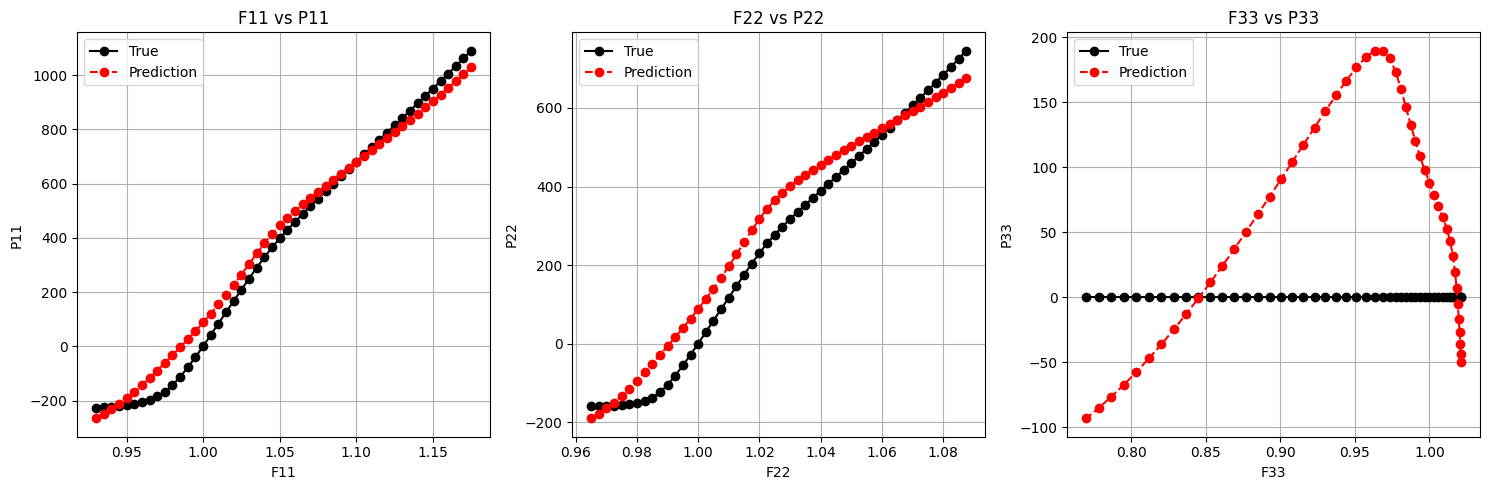

In [16]:
def plot_all_stress_vs_deformation(F_train, P_train, P_train_pred):

    F11 = F_train[:, 0, 0]  
    F22 = F_train[:, 1, 1]  
    F33 = F_train[:, 2, 2] 

    P11 = P_train[:, 0, 0]  
    P22 = P_train[:, 1, 1]  
    P33 = P_train[:, 2, 2]  

    P11_pred = P_train_pred[:, 0, 0] 
    P22_pred = P_train_pred[:, 1, 1] 
    P33_pred = P_train_pred[:, 2, 2] 


    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    ax1 = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]

    ax1.plot(F11, P11, label="True", marker="o", linestyle="-", color="black")
    ax1.plot(F11, P11_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax1.set_xlabel("F11")
    ax1.set_ylabel("P11")
    ax1.set_title("F11 vs P11")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(F22, P22, label="True", marker="o", linestyle="-", color="black")
    ax2.plot(F22, P22_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax2.set_xlabel("F22")
    ax2.set_ylabel("P22")
    ax2.set_title("F22 vs P22")
    ax2.legend()
    ax2.grid(True)

    ax3.plot(F33, P33, label="True", marker="o", linestyle="-", color="black")
    ax3.plot(F33, P33_pred, label="Prediction", marker="o", linestyle="--", color="red")
    ax3.set_xlabel("F33")
    ax3.set_ylabel("P33")
    ax3.set_title("F33 vs P33")
    ax3.legend()
    ax3.grid(True)

  
    plt.tight_layout()
    plt.show()


plot_all_stress_vs_deformation(F_train[:50], P_train[:50], P_train_pred[:50])
plot_all_stress_vs_deformation(F_test1[:50], P_test1[:50], P_test_pred[:50])
plot_all_stress_vs_deformation(F_test1[50:100], P_test1[50:100], P_test_pred[50:100])


### 5.3

In [14]:

import models_dg as lm2

import importlib
importlib.reload(lm2)
models_dg = lm2.main()

models_dg.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 19)]              0         
                                                                 
 private_c_to_w_2 (_C_to_W)  multiple                  609       
                                                                 
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


In [15]:
Cof_F_train = np.linalg.det(F_train)[:, None, None] * np.linalg.inv(F_train.transpose(0, 2, 1))
det_F_train = np.linalg.det(F_train)

In [16]:
F_input = np.concatenate([F_train.reshape(-1,9), Cof_F_train.reshape(-1,9), det_F_train[:, None] ], axis=1)
F_input_tensor = tf.convert_to_tensor(F_input, dtype=tf.float32)

In [23]:
print(F_input_tensor.shape)
print(W_train_tensor.shape)
print(P_train_tensor.shape)

(411, 19)
(411,)
(411, 9)


In [24]:
history = models_dg.fit(F_input_tensor, [W_train_tensor,P_train_tensor], epochs=2500)


import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()


Epoch 1/2500


TypeError: 'NoneType' object is not callable

In [38]:
from scipy.stats import special_ortho_group
import numpy as np

def apply_rotation(F_input, num_samples=100):
    """对输入数据 F_input 应用旋转矩阵，并生成新的输入 QF_input"""
    QF_inputs = []
    for _ in range(num_samples):
        # 生成随机旋转矩阵 Q
        Q = special_ortho_group.rvs(3)

        # 提取 F, Cof(F), det(F) 的分量
        F = F_input[:, :9].reshape(-1, 3, 3)       # 提取 F 并重塑为矩阵形式
        Cof_F = F_input[:, 9:18].reshape(-1, 3, 3) # 提取 Cof(F)
        det_F = F_input[:, 18]                    # 提取 det(F)

        # 计算 QF
        QF = np.einsum('ij,bjk->bik', Q, F)  # Q * F

        # 计算 Cof(QF) 和 det(QF)
        Cof_QF = np.einsum('ij,bjk->bik', Q, Cof_F)  # Cof(QF) = Q * Cof(F)，因为 det(Q) = 1
        det_QF = det_F  # det(QF) = det(F)

        # 拼接 QF_input
        QF_input = np.concatenate(
            [QF.reshape(-1, 9), Cof_QF.reshape(-1, 9), det_QF[:, None]], axis=1
        )
        QF_inputs.append(QF_input)

    return QF_inputs


In [40]:
# 生成 QF_inputs
num_samples = 100
QF_inputs = apply_rotation(F_input, num_samples=num_samples)

# 验证旋转不变性
results = []
for QF_input in QF_inputs:
    W_original = models_dg.predict(F_input)  # 原始 W(F)
    W_rotated = models_dg.predict(QF_input) # 旋转后的 W(QF)
    results.append(np.allclose(W_original, W_rotated, atol=1e-5))  # 检查一致性

# 打印不变性结果
consistency = np.mean(results)
print(f"Consistency of invariance condition: {consistency * 100:.2f}%")


13/13 [==============================] - 0s 836us/step
Consistency of invariance condition: 0.00%


13/13 [==============================] - 0s 822us/step


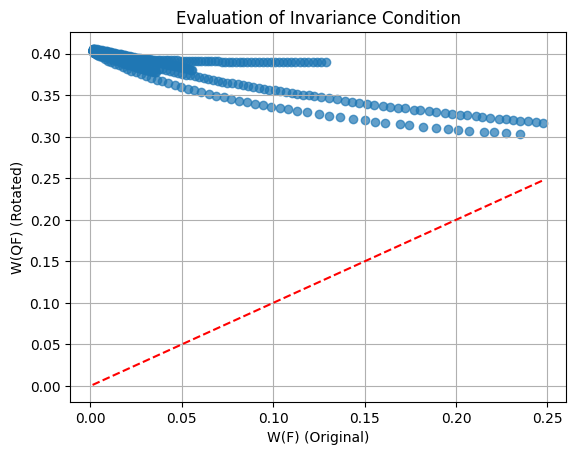

In [39]:
import matplotlib.pyplot as plt

# 选择其中一个 QF_input 的预测值进行对比
QF_input = QF_inputs[0]
W_original = models_dg.predict(F_input)
W_rotated = models_dg.predict(QF_input)

# 绘制散点图
plt.scatter(W_original, W_rotated, alpha=0.7)
plt.plot([W_original.min(), W_original.max()], [W_original.min(), W_original.max()], 'r--')  # 对角线
plt.xlabel("W(F) (Original)")
plt.ylabel("W(QF) (Rotated)")
plt.title("Evaluation of Invariance Condition")
plt.grid(True)
plt.show()


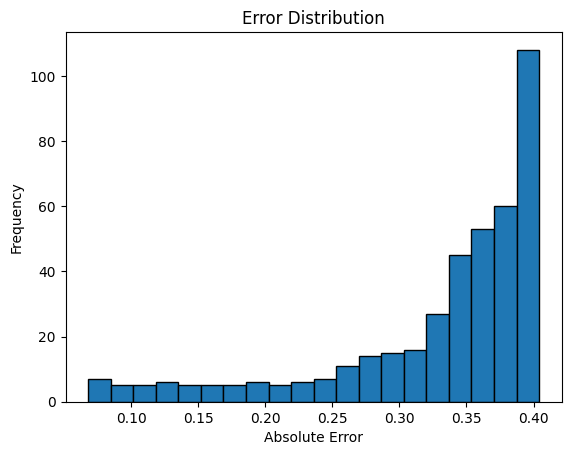

In [37]:
errors = np.abs(W_original - W_rotated)
plt.hist(errors, bins=20, edgecolor='black')
plt.title("Error Distribution")
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.show()


### 5.3

In [28]:
import numpy as np
data_biaxial = np.loadtxt('../../BCC/BCC_biaxial.txt')
data_shear = np.loadtxt('../../BCC/BCC_shear.txt')
data_planar = np.loadtxt('../../BCC/BCC_planar.txt')
data_test1 = np.loadtxt('../../BCC/BCC_test1.txt')
data_test2 = np.loadtxt('../../BCC/BCC_test2.txt')
data_test3 = np.loadtxt('../../BCC/BCC_test3.txt')

def process_data(data):

    F = data[:, :9].reshape(-1, 3, 3) 
    P = data[:, 9:18].reshape(-1, 3, 3)  
    SE = data[:, 18] 
    return F, P, SE


F_biaxial, P_biaxial, W_biaxial = process_data(data_biaxial)
F_shear, P_shear, W_shear = process_data(data_shear)
F_planar, P_planar, W_planar = process_data(data_planar)
F_test1, P_test1, W_test1 = process_data(data_test1)
F_test2, P_test2, W_test2 = process_data(data_test2)
F_test3, P_test3, W_test3 = process_data(data_test3)

In [35]:
F_all = np.concatenate([F_biaxial, F_shear, F_planar], axis=0)

In [ ]:
Cof_F_train = np.linalg.det(F_all)[:, None, None] * np.linalg.inv(F_all.transpose(0, 2, 1))
det_F_train = np.linalg.det(F_all)
F_train = np.concatenate([F_all.reshape(-1,9), Cof_F_train.reshape(-1,9), det_F_train[:, None] ], axis=1)
P_train = np.concatenate([P_biaxial.reshape(-1,9), P_shear.reshape(-1,9), P_planar.reshape(-1,9)], axis=0)
W_train = np.concatenate([W_biaxial, W_shear, W_planar], axis=0)

In [39]:
print(F_train.shape)
print(P_train.shape)
print(W_train.shape)

(411, 19)
(411, 9)
(411,)


In [46]:
def scale_data(P_train, W_train):
    # Step 1: 计算缩放因子 a
    # 这里使用 P_train 中所有分量的最大绝对值的倒数
    max_abs_P = np.max(np.abs(P_train))
    a = 1.0 / max_abs_P

    # Step 2: 应用缩放因子到应力张量和应变能
    P_train_scaled = a * P_train
    W_train_scaled = a * W_train

    return P_train_scaled, W_train_scaled, a

P_train_scaled, W_train_scaled, a = scale_data(P_train, W_train)

In [6]:
def random_rotation_matrix():
    """Generate a random 3x3 rotation matrix Q in SO(3)."""
    random_vector = np.random.normal(size=(3,))
    random_vector /= np.linalg.norm(random_vector)
    theta = np.random.uniform(0, 2 * np.pi)

    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    ux, uy, uz = random_vector

    Q = np.array([
        [cos_theta + ux**2 * (1 - cos_theta), ux * uy * (1 - cos_theta) - uz * sin_theta, ux * uz * (1 - cos_theta) + uy * sin_theta],
        [uy * ux * (1 - cos_theta) + uz * sin_theta, cos_theta + uy**2 * (1 - cos_theta), uy * uz * (1 - cos_theta) - ux * sin_theta],
        [uz * ux * (1 - cos_theta) - uy * sin_theta, uz * uy * (1 - cos_theta) + ux * sin_theta, cos_theta + uz**2 * (1 - cos_theta)],
    ])
    return Q


Epoch 1/2500
13/13 [==============================] - 1s 1ms/step - loss: 0.0895 - loss_W: 0.0651 - loss_P: 0.0245
Epoch 2/2500
13/13 [==============================] - 0s 1ms/step - loss: 0.0391 - loss_W: 0.0142 - loss_P: 0.0249
Epoch 3/2500
13/13 [==============================] - 0s 1ms/step - loss: 0.0303 - loss_W: 0.0065 - loss_P: 0.0238
Epoch 4/2500
13/13 [==============================] - 0s 1ms/step - loss: 0.0267 - loss_W: 0.0039 - loss_P: 0.0228
Epoch 5/2500
13/13 [==============================] - 0s 1ms/step - loss: 0.0263 - loss_W: 0.0040 - loss_P: 0.0223
Epoch 6/2500
13/13 [==============================] - 0s 1ms/step - loss: 0.0254 - loss_W: 0.0039 - loss_P: 0.0215
Epoch 7/2500
13/13 [==============================] - 0s 1ms/step - loss: 0.0248 - loss_W: 0.0040 - loss_P: 0.0208
Epoch 8/2500
13/13 [==============================] - 0s 2ms/step - loss: 0.0259 - loss_W: 0.0043 - loss_P: 0.0216
Epoch 9/2500
13/13 [==============================] - 0s 2ms/step - loss: 0.0248

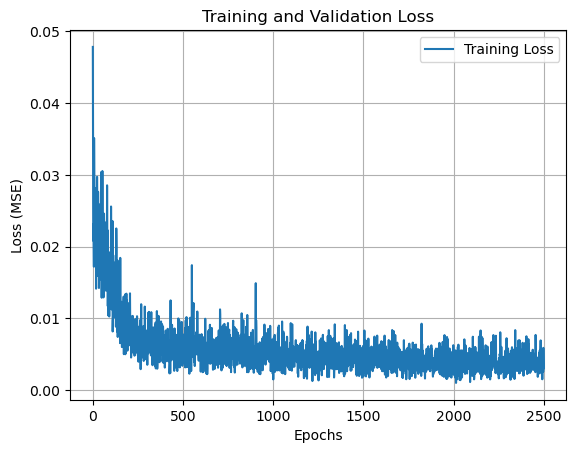

In [47]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = layers.Dense(64, activation='softplus')
        self.dense2 = layers.Dense(64, activation='softplus')
        self.out_layer = layers.Dense(1, activation='linear')

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.out_layer(x)

    def train_step(self, data):

        X_batch, y_batch = data
        W_batch, P_batch = y_batch  

        with tf.GradientTape() as tape:
            with tf.GradientTape() as tape_F:
                tape_F.watch(X_batch)
                W_pred = self(X_batch, training=True)
            

            dW_dF = tape_F.gradient(W_pred, X_batch)[:, :9]


            loss_W = tf.reduce_mean((W_pred - W_batch)**2)
            loss_P = tf.reduce_mean((dW_dF - P_batch)**2)
            loss = loss_W + loss_P


        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))


        return {"loss": loss, "loss_W": loss_W, "loss_P": loss_P}




model = MyModel()
model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001))


history=model.fit(F_train, (W_train_scaled, P_train_scaled), epochs=2500)
plt.plot(history.history['loss'], label='Training Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training and Validation Loss")
plt.grid(True)
plt.show()


In [49]:
Cof_F_test = np.linalg.det(F_test1)[:, None, None] * np.linalg.inv(F_test1.transpose(0, 2, 1))
det_F_test = np.linalg.det(F_test1)
F_test = np.concatenate([F_test1.reshape(-1,9), Cof_F_test.reshape(-1,9), det_F_test[:, None] ], axis=1)


5/5 [==============================] - 0s 1ms/step


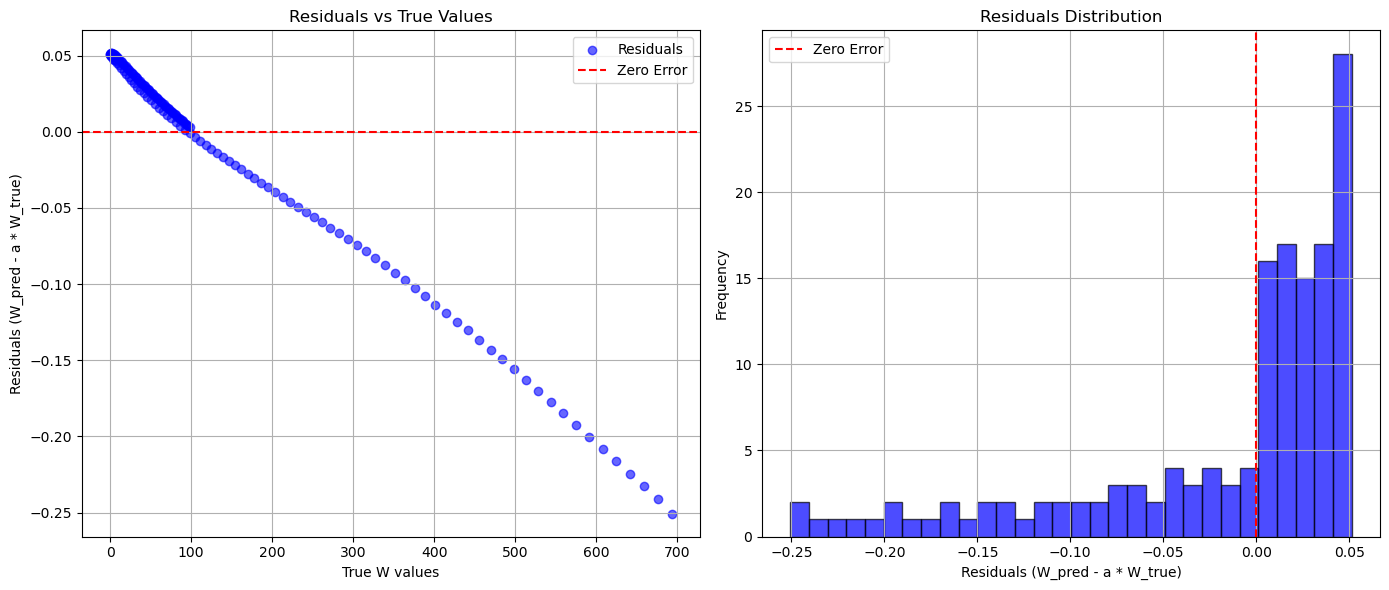

In [57]:
import matplotlib.pyplot as plt
W_pred = model.predict(F_test)
residuals = W_pred.flatten() - a * W_test1.flatten()  # 展平数组以便绘图

# 创建图形
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# 残差图
axs[0].scatter(W_test1.flatten(), residuals, alpha=0.6, color='blue', label="Residuals")
axs[0].axhline(0, color='red', linestyle='--', label="Zero Error")
axs[0].set_xlabel("True W values")
axs[0].set_ylabel("Residuals (W_pred - a * W_true)")
axs[0].set_title("Residuals vs True Values")
axs[0].legend()
axs[0].grid(True)

# 残差分布直方图
axs[1].hist(residuals, bins=30, color='blue', alpha=0.7, edgecolor='black')
axs[1].axvline(0, color='red', linestyle='--', label="Zero Error")
axs[1].set_xlabel("Residuals (W_pred - a * W_true)")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Residuals Distribution")
axs[1].legend()
axs[1].grid(True)

# 显示图形
plt.tight_layout()
plt.show()



### 5.4

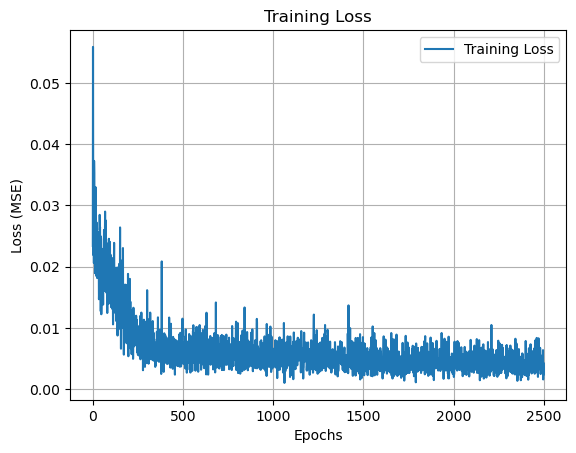

In [77]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

# Load data
data_biaxial = np.loadtxt('../../BCC/BCC_biaxial.txt')
data_shear = np.loadtxt('../../BCC/BCC_shear.txt')
data_planar = np.loadtxt('../../BCC/BCC_planar.txt')
data_test1 = np.loadtxt('../../BCC/BCC_test1.txt')
data_test2 = np.loadtxt('../../BCC/BCC_test2.txt')
data_test3 = np.loadtxt('../../BCC/BCC_test3.txt')

# Process data
def process_data(data):
    F = data[:, :9].reshape(-1, 3, 3)  # Deformation Gradient Tensor
    P = data[:, 9:18].reshape(-1, 3, 3)  # First Piola-Kirchhoff Stress Tensor
    SE = data[:, 18]  # Strain Energy Density
    return F, P, SE

# Extract data
F_biaxial, P_biaxial, W_biaxial = process_data(data_biaxial)
F_shear, P_shear, W_shear = process_data(data_shear)
F_planar, P_planar, W_planar = process_data(data_planar)

# Combine training data
F_all = np.concatenate([F_biaxial, F_shear, F_planar], axis=0)
P_train = np.concatenate([P_biaxial.reshape(-1, 9), P_shear.reshape(-1, 9), P_planar.reshape(-1, 9)], axis=0)
W_train = np.concatenate([W_biaxial, W_shear, W_planar], axis=0)

# Compute cofactors and determinant of deformation gradient tensors
Cof_F_train = np.linalg.det(F_all)[:, None, None] * np.linalg.inv(F_all.transpose(0, 2, 1))
det_F_train = np.linalg.det(F_all)

# Prepare input data for training
F_train = np.concatenate([F_all.reshape(-1, 9), Cof_F_train.reshape(-1, 9), det_F_train[:, None]], axis=1)

# Scale data
def scale_data(P_train, W_train):
    max_abs_P = np.max(np.abs(P_train))  # Calculate scaling factor
    a = 1.0 / max_abs_P
    P_train_scaled = a * P_train
    W_train_scaled = a * W_train
    return P_train_scaled, W_train_scaled, a

P_train_scaled, W_train_scaled, a = scale_data(P_train, W_train)

# Define the custom model
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = layers.Dense(64, activation='softplus')
        self.dense2 = layers.Dense(64, activation='softplus')
        self.out_layer = layers.Dense(1, activation='linear')

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.out_layer(x)

    def train_step(self, data):
        X_batch, y_batch = data
        W_batch, P_batch = y_batch  # Separate targets

        with tf.GradientTape() as tape:
            with tf.GradientTape() as tape_F:
                tape_F.watch(X_batch)
                W_pred = self(X_batch, training=True)

            dW_dF = tape_F.gradient(W_pred, X_batch)[:, :9]
            loss_W = tf.reduce_mean((W_pred - W_batch) ** 2)
            loss_P = tf.reduce_mean((dW_dF - P_batch) ** 2)
            loss = loss_W + loss_P

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"loss": loss, "loss_W": loss_W, "loss_P": loss_P}

# Train the model
model = MyModel()
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001))
history = model.fit(F_train, (W_train_scaled, P_train_scaled), epochs=2500, verbose=0)

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training Loss")
plt.grid(True)
plt.show()


In [78]:
import matplotlib.pyplot as plt

Cof_F_test = np.linalg.det(F_test1)[:, None, None] * np.linalg.inv(F_test1.transpose(0, 2, 1))
det_F_test = np.linalg.det(F_test1)
F_test = np.concatenate([F_test1.reshape(-1,9), Cof_F_test.reshape(-1,9), det_F_test[:, None] ], axis=1)
W_pred = model.predict(F_test)



5/5 [==============================] - 0s 1ms/step


In [79]:
import tensorflow as tf

F_test_input_tf = tf.convert_to_tensor(F_test, dtype=tf.float32)

with tf.GradientTape() as tape:
    tape.watch(F_test_input_tf)
    W_test_pred_tf = model(F_test_input_tf, training=False)  # 预测 W_test

P_test_pred_tf = tape.gradient(W_test_pred_tf, F_test_input_tf)[:, :9]  # 计算 P_test 的梯度
P_test_pred = P_test_pred_tf.numpy().reshape(-1, 3, 3)  # 转换为 NumPy 格式
P_test_unscaled = P_test_pred / a  # 使用之前计算的缩放因子 a

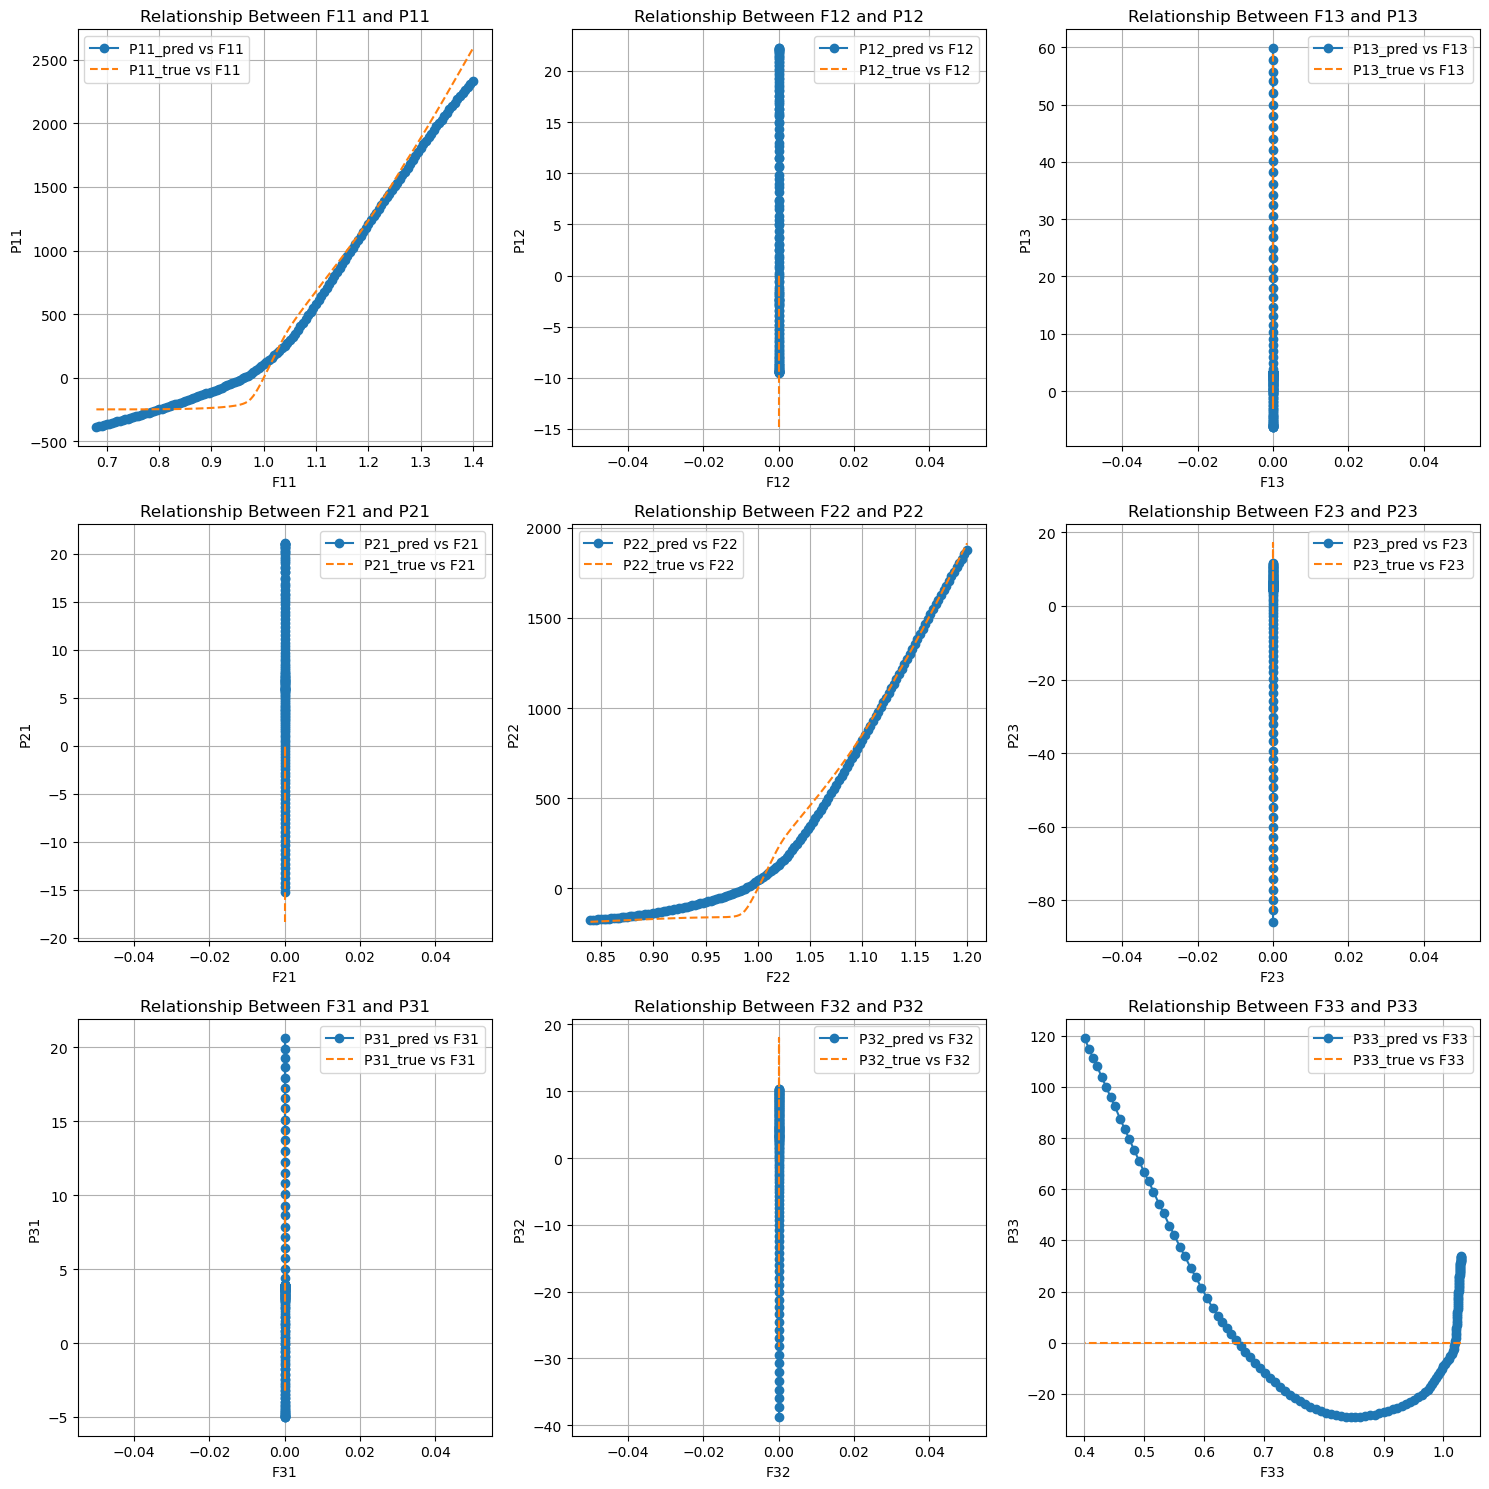

In [66]:
# Extract all components F11 to F33 and P11 to P33
components = ['11', '12', '13', '21', '22', '23', '31', '32', '33']

# Create subplots for each pair of Fij and Pij
plt.figure(figsize=(15, 15))
for i, comp in enumerate(components):
    F_comp = F_test1[:, i // 3, i % 3]  # Extract corresponding F component
    P_pred_comp = P_test_unscaled[:, i // 3, i % 3]  # Predicted P component
    P_true_comp = P_test1[:, i // 3, i % 3]  # True P component

    plt.subplot(3, 3, i + 1)
    plt.plot(F_comp, P_pred_comp, 'o-', label=f'P{comp}_pred vs F{comp}')
    plt.plot(F_comp, P_true_comp, '--', label=f'P{comp}_true vs F{comp}')
    plt.xlabel(f'F{comp}')
    plt.ylabel(f'P{comp}')
    plt.title(f'Relationship Between F{comp} and P{comp}')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()


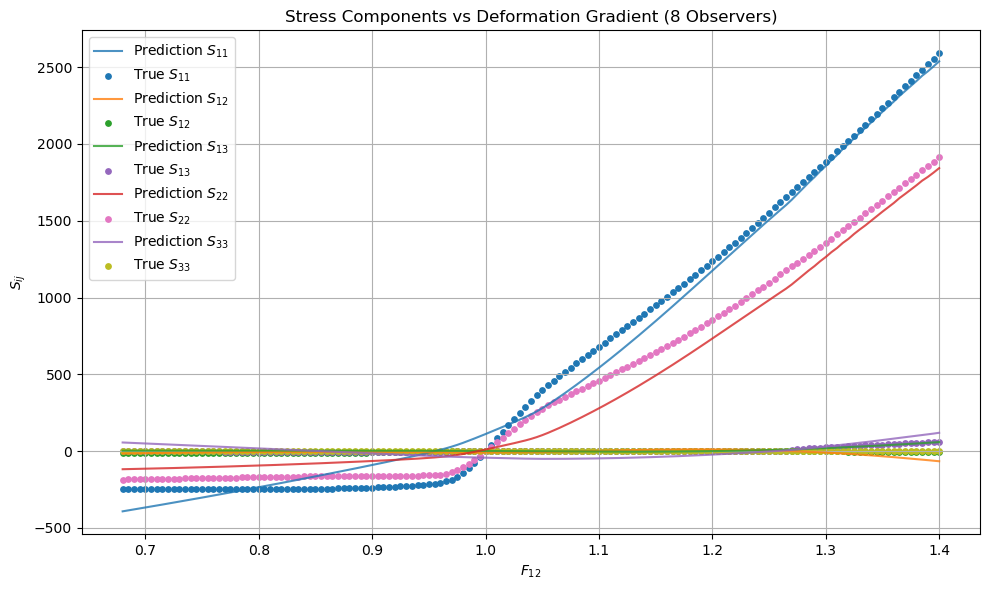

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# 假设 F12 是变形梯度的 F12 分量
F12 = F_test[:, 0]  # 选择 F12 作为横轴

# 解缩放后的预测应力张量
S11_pred = P_test_unscaled[:, 0, 0]
S12_pred = P_test_unscaled[:, 0, 1]
S13_pred = P_test_unscaled[:, 0, 2]
S22_pred = P_test_unscaled[:, 1, 1]
S33_pred = P_test_unscaled[:, 2, 2]

# 真实值 P_test1
S11_true = P_test1[:, 0, 0]
S12_true = P_test1[:, 0, 1]
S13_true = P_test1[:, 0, 2]
S22_true = P_test1[:, 1, 1]
S33_true = P_test1[:, 2, 2]

# 将不同应力分量放入列表
stress_components_pred = [S11_pred, S12_pred, S13_pred, S22_pred, S33_pred]
stress_components_true = [S11_true, S12_true, S13_true, S22_true, S33_true]
component_labels = [r"$S_{11}$", r"$S_{12}$", r"$S_{13}$", r"$S_{22}$", r"$S_{33}$"]

# 绘制应力-变形图
plt.figure(figsize=(10, 6))

for pred, true, label in zip(stress_components_pred, stress_components_true, component_labels):
    # 画预测值曲线
    plt.plot(F12, pred, label=f"Prediction {label}", alpha=0.8)
    # 画真实值点
    plt.scatter(F12, true, label=f"True {label}", s=15)
    # 误差带
    plt.fill_between(
        F12,
        pred - 0.5,  # 模拟误差范围
        pred + 0.5,
        alpha=0.2,
    )

plt.title("Stress Components vs Deformation Gradient (8 Observers)")
plt.xlabel(r"$F_{12}$")
plt.ylabel(r"$S_{ij}$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

# Load and process the data (same as before)
def process_data(data):
    F = data[:, :9].reshape(-1, 3, 3)  # Deformation Gradient Tensor
    P = data[:, 9:18].reshape(-1, 3, 3)  # First Piola-Kirchhoff Stress Tensor
    SE = data[:, 18]  # Strain Energy Density
    return F, P, SE

# Generate random rotation matrices
def generate_rotation_matrices(num_matrices):
    rotations = []
    for _ in range(num_matrices):
        q = np.random.randn(4)  # Random quaternion
        q /= np.linalg.norm(q)  # Normalize quaternion
        r = np.array([[1 - 2 * (q[2]**2 + q[3]**2), 2 * (q[1]*q[2] - q[3]*q[0]), 2 * (q[1]*q[3] + q[2]*q[0])],
                      [2 * (q[1]*q[2] + q[3]*q[0]), 1 - 2 * (q[1]**2 + q[3]**2), 2 * (q[2]*q[3] - q[1]*q[0])],
                      [2 * (q[1]*q[3] - q[2]*q[0]), 2 * (q[2]*q[3] + q[1]*q[0]), 1 - 2 * (q[1]**2 + q[2]**2)]])
        rotations.append(r)
    return np.array(rotations)

# Augment the dataset
def augment_data(F, P, W, num_rotations=16):
    rotation_matrices = generate_rotation_matrices(num_rotations)
    F_augmented, P_augmented, W_augmented = [], [], []
    for Q in rotation_matrices:
        for Fi, Pi, Wi in zip(F, P, W):
            F_aug = Q @ Fi @ Q.T
            P_aug = Q @ Pi @ Q.T
            F_augmented.append(F_aug)
            P_augmented.append(P_aug)
            W_augmented.append(Wi)
    return np.array(F_augmented), np.array(P_augmented), np.array(W_augmented), rotation_matrices

# Load your data

data_shear = np.loadtxt('../../BCC/BCC_shear.txt')

data_uniaxial = np.loadtxt('../../BCC/BCC_uniaxial.txt')


F_shear, P_shear, W_shear = process_data(data_shear)
F_uniaxial, P_uniaxial, W_uniaxial = process_data(data_uniaxial)

# Combine training data
F_all = np.concatenate([F_shear, F_uniaxial], axis=0)
P_train = np.concatenate([P_shear.reshape(-1, 9), P_uniaxial.reshape(-1, 9)], axis=0)
W_train = np.concatenate([W_shear, W_uniaxial], axis=0)

# Augment the data
F_augmented, P_augmented, W_augmented, _ = augment_data(F_all, P_train.reshape(-1, 3, 3), W_train, num_rotations=16)

# Prepare input data for training
Cof_F_train = np.linalg.det(F_augmented)[:, None, None] * np.linalg.inv(F_augmented.transpose(0, 2, 1))
det_F_train = np.linalg.det(F_augmented)
F_train = np.concatenate([F_augmented.reshape(-1, 9), Cof_F_train.reshape(-1, 9), det_F_train[:, None]], axis=1)

# Scale data
def scale_data(P_train, W_train):
    max_abs_P = np.max(np.abs(P_train))  # Calculate scaling factor
    a = 1.0 / max_abs_P
    P_train_scaled = a * P_train
    W_train_scaled = a * W_train
    return P_train_scaled, W_train_scaled, a

P_train_scaled, W_train_scaled, a = scale_data(P_augmented.reshape(-1, 9), W_augmented)




Epoch 1/1000
138/138 [==============================] - 0s 1ms/step - loss: 0.1594 - loss_W: 0.1288 - loss_P: 0.0306
Epoch 2/1000
138/138 [==============================] - 0s 1ms/step - loss: 0.0336 - loss_W: 0.0047 - loss_P: 0.0288
Epoch 3/1000
138/138 [==============================] - 0s 1ms/step - loss: 0.0322 - loss_W: 0.0048 - loss_P: 0.0274
Epoch 4/1000
138/138 [==============================] - 0s 1ms/step - loss: 0.0313 - loss_W: 0.0048 - loss_P: 0.0265
Epoch 5/1000
138/138 [==============================] - 0s 1ms/step - loss: 0.0308 - loss_W: 0.0048 - loss_P: 0.0260
Epoch 6/1000
138/138 [==============================] - 0s 1ms/step - loss: 0.0302 - loss_W: 0.0047 - loss_P: 0.0255
Epoch 7/1000
138/138 [==============================] - 0s 1ms/step - loss: 0.0298 - loss_W: 0.0049 - loss_P: 0.0249
Epoch 8/1000
138/138 [==============================] - 0s 2ms/step - loss: 0.0288 - loss_W: 0.0049 - loss_P: 0.0239
Epoch 9/1000
138/138 [==============================] - 0s 1ms/s

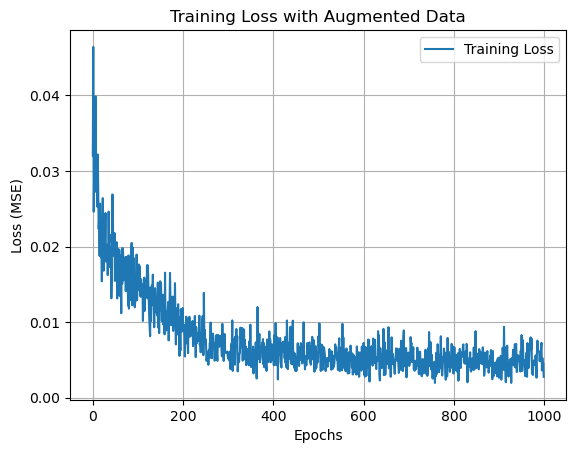

In [25]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = layers.Dense(64, activation='softplus')
        self.dense2 = layers.Dense(64, activation='softplus')
        self.out_layer = layers.Dense(1, activation='linear')

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.out_layer(x)

    def train_step(self, data):
        X_batch, y_batch = data
        W_batch, P_batch = y_batch  # Separate targets

        with tf.GradientTape() as tape:
            with tf.GradientTape() as tape_F:
                tape_F.watch(X_batch)
                W_pred = self(X_batch, training=True)

            dW_dF = tape_F.gradient(W_pred, X_batch)[:, :9]
            loss_W = tf.reduce_mean((W_pred - W_batch) ** 2)
            loss_P = tf.reduce_mean((dW_dF - P_batch) ** 2)
            loss = loss_W + loss_P

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"loss": loss, "loss_W": loss_W, "loss_P": loss_P}
# Train the model
model = MyModel()
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001))
history = model.fit(F_train, (W_train_scaled, P_train_scaled), epochs=1000)

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title("Training Loss with Augmented Data")
plt.grid(True)
plt.show()

In [26]:
F_1024, P_1024, W_1024, rotation_matrices = augment_data(F_all, P_train.reshape(-1, 3, 3), W_train, num_rotations=1024)


In [27]:
print(rotation_matrices.shape)

(1024, 3, 3)


In [28]:
# 生成 1024 个观察者的增强数据

Cof_F_1024 = np.linalg.det(F_1024)[:, None, None] * np.linalg.inv(F_1024.transpose(0, 2, 1))
det_F_1024 = np.linalg.det(F_1024)
F_1024_input = np.concatenate([F_1024.reshape(-1, 9), Cof_F_1024.reshape(-1, 9), det_F_1024[:, None]], axis=1)

# 模型预测
F_1024_input = tf.convert_to_tensor(F_1024_input, dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(F_1024_input)
    W_1024_tf = model(F_1024_input, training=False)
P_1024_tf = tape.gradient(W_1024_tf, F_1024_input)[:, :9]
P_1024_pred = P_1024_tf.numpy().reshape(1024, -1, 3, 3) / a  # 解缩放



In [29]:
print(P_1024_pred.shape)

(1024, 276, 3, 3)


In [32]:
print(S11_true.shape)

(276,)


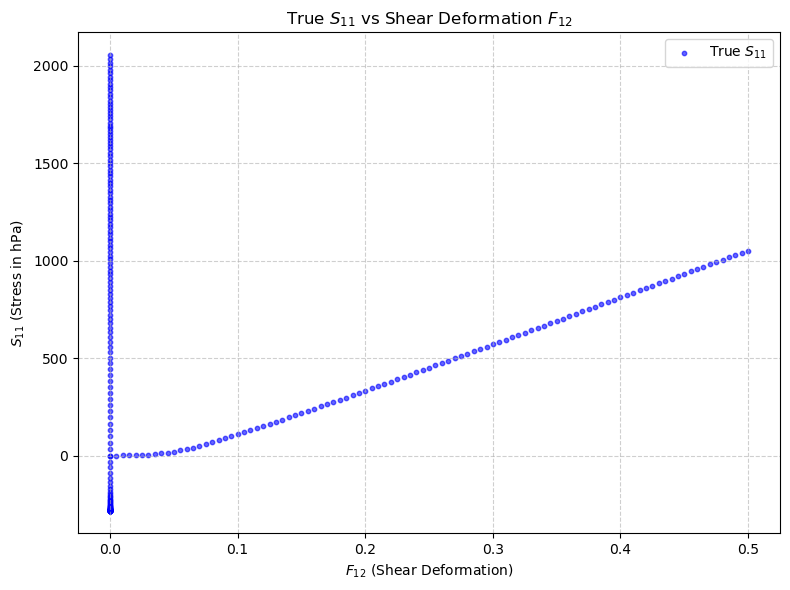

In [33]:
import matplotlib.pyplot as plt

# 提取模拟值的 S11 和 F12
S11_true = P_train[:, 0].reshape(-1)  # 模拟值 S11
F12_true = F_all[:, 0, 1]  # 提取 F12 分量

# 绘制 F12_true 与 S11_true 的关系图
plt.figure(figsize=(8, 6))
plt.scatter(F12_true, S11_true, label=r"True $S_{11}$", color="blue", alpha=0.6, s=10)

# 设置图形属性
plt.title("True $S_{11}$ vs Shear Deformation $F_{12}$")
plt.xlabel(r"$F_{12}$ (Shear Deformation)")
plt.ylabel(r"$S_{11}$ (Stress in hPa)")
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


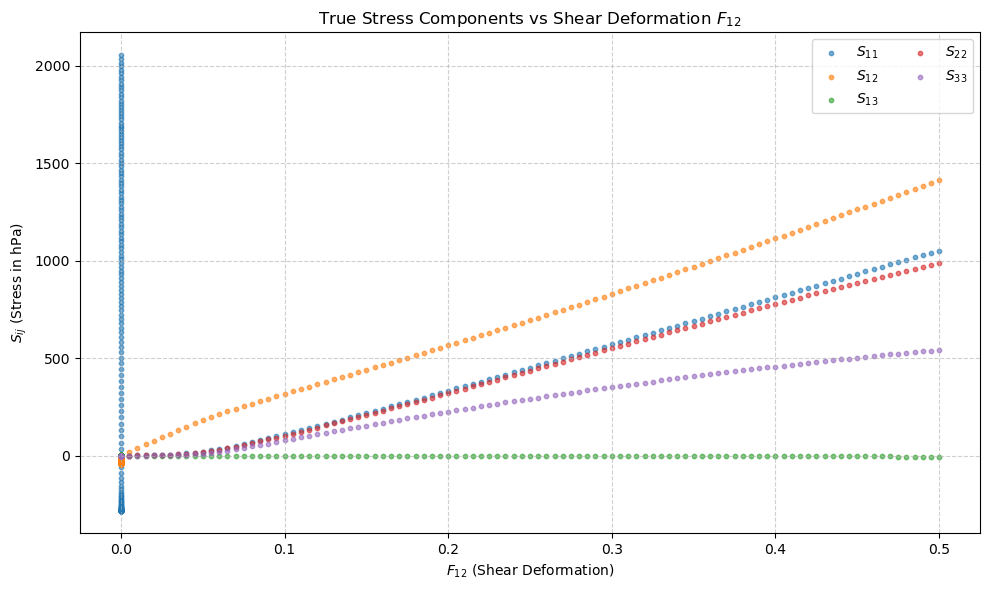

In [31]:
import matplotlib.pyplot as plt

# 提取模拟值的应力分量
S11_true = P_train[:, 0].reshape(-1)  # 模拟值 S11
S12_true = P_train[:, 1].reshape(-1)  # 模拟值 S12
S13_true = P_train[:, 2].reshape(-1)  # 模拟值 S13
S22_true = P_train[:, 4].reshape(-1)  # 模拟值 S22
S33_true = P_train[:, 8].reshape(-1)  # 模拟值 S33

# 模拟值的剪切分量 F12_true
F12_true = F_all[:, 0, 1]  # 提取 F12 分量

# 应力分量及其标签
stress_components = [S11_true, S12_true, S13_true, S22_true, S33_true]
component_labels = [r"$S_{11}$", r"$S_{12}$", r"$S_{13}$", r"$S_{22}$", r"$S_{33}$"]
colors = plt.cm.tab10(range(len(component_labels)))

# 绘制 F12_true 与 S 的关系图
plt.figure(figsize=(10, 6))
for stress, label, color in zip(stress_components, component_labels, colors):
    plt.scatter(F12_true, stress, label=label, color=color, alpha=0.6, s=10)

# 设置图形属性
plt.title("True Stress Components vs Shear Deformation $F_{12}$")
plt.xlabel(r"$F_{12}$ (Shear Deformation)")
plt.ylabel(r"$S_{ij}$ (Stress in hPa)")
plt.legend(ncol=2, fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [83]:
import tensorflow as tf

F_test_input_tf = tf.convert_to_tensor(F_test, dtype=tf.float32)

with tf.GradientTape() as tape:
    tape.watch(F_test_input_tf)
    W_test_pred_tf = model(F_test_input_tf, training=False)  # 预测 W_test

P_test_pred_tf = tape.gradient(W_test_pred_tf, F_test_input_tf)[:, :9]  # 计算 P_test 的梯度
P_test_pred = P_test_pred_tf.numpy().reshape(-1, 3, 3)  # 转换为 NumPy 格式
P_test_unscaled = P_test_pred / a  # 使用之前计算的缩放因子 a

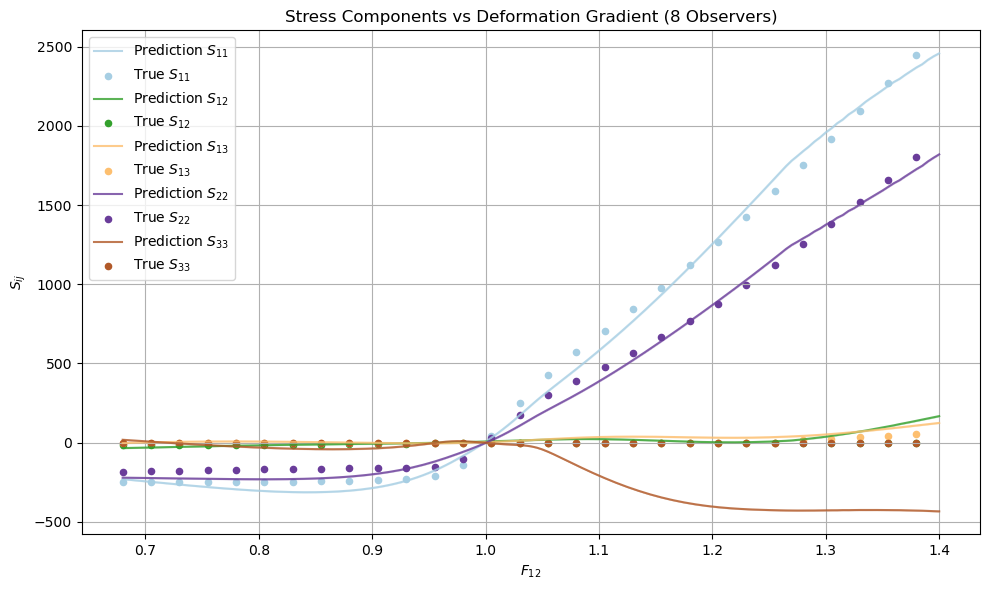

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# 假设 F12 是变形梯度的 F12 分量
F12 = F_test[:, 0]  # 选择 F12 作为横轴

# 解缩放后的预测应力张量
S11_pred = P_test_unscaled[:, 0, 0]
S12_pred = P_test_unscaled[:, 0, 1]
S13_pred = P_test_unscaled[:, 0, 2]
S22_pred = P_test_unscaled[:, 1, 1]
S33_pred = P_test_unscaled[:, 2, 2]

# 真实值 P_test1
S11_true = P_test1[:, 0, 0]
S12_true = P_test1[:, 0, 1]
S13_true = P_test1[:, 0, 2]
S22_true = P_test1[:, 1, 1]
S33_true = P_test1[:, 2, 2]

# 将不同应力分量放入列表
stress_components_pred = [S11_pred, S12_pred, S13_pred, S22_pred, S33_pred]
stress_components_true = [S11_true, S12_true, S13_true, S22_true, S33_true]
component_labels = [r"$S_{11}$", r"$S_{12}$", r"$S_{13}$", r"$S_{22}$", r"$S_{33}$"]

# 设置亮色颜色映射
colors = plt.cm.Paired(np.linspace(0, 1, len(component_labels)))  # 使用亮色配色

# 真实值点采样（每隔 5 个点）
sample_indices = np.arange(0, len(F12), 5)

# 绘制应力-变形图
plt.figure(figsize=(10, 6))

for pred, true, label, color in zip(stress_components_pred, stress_components_true, component_labels, colors):
    # 画预测值曲线
    plt.plot(F12, pred, label=f"Prediction {label}", alpha=0.8, color=color)
    # 画真实值点（采样点）
    plt.scatter(F12[sample_indices], true[sample_indices], label=f"True {label}", s=20, color=color)
    # 误差带
    plt.fill_between(
        F12,
        pred - 0.5,  # 模拟误差范围
        pred + 0.5,
        alpha=0.2,
        color=color,
    )

plt.title("Stress Components vs Deformation Gradient (8 Observers)")
plt.xlabel(r"$F_{12}$")
plt.ylabel(r"$S_{ij}$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


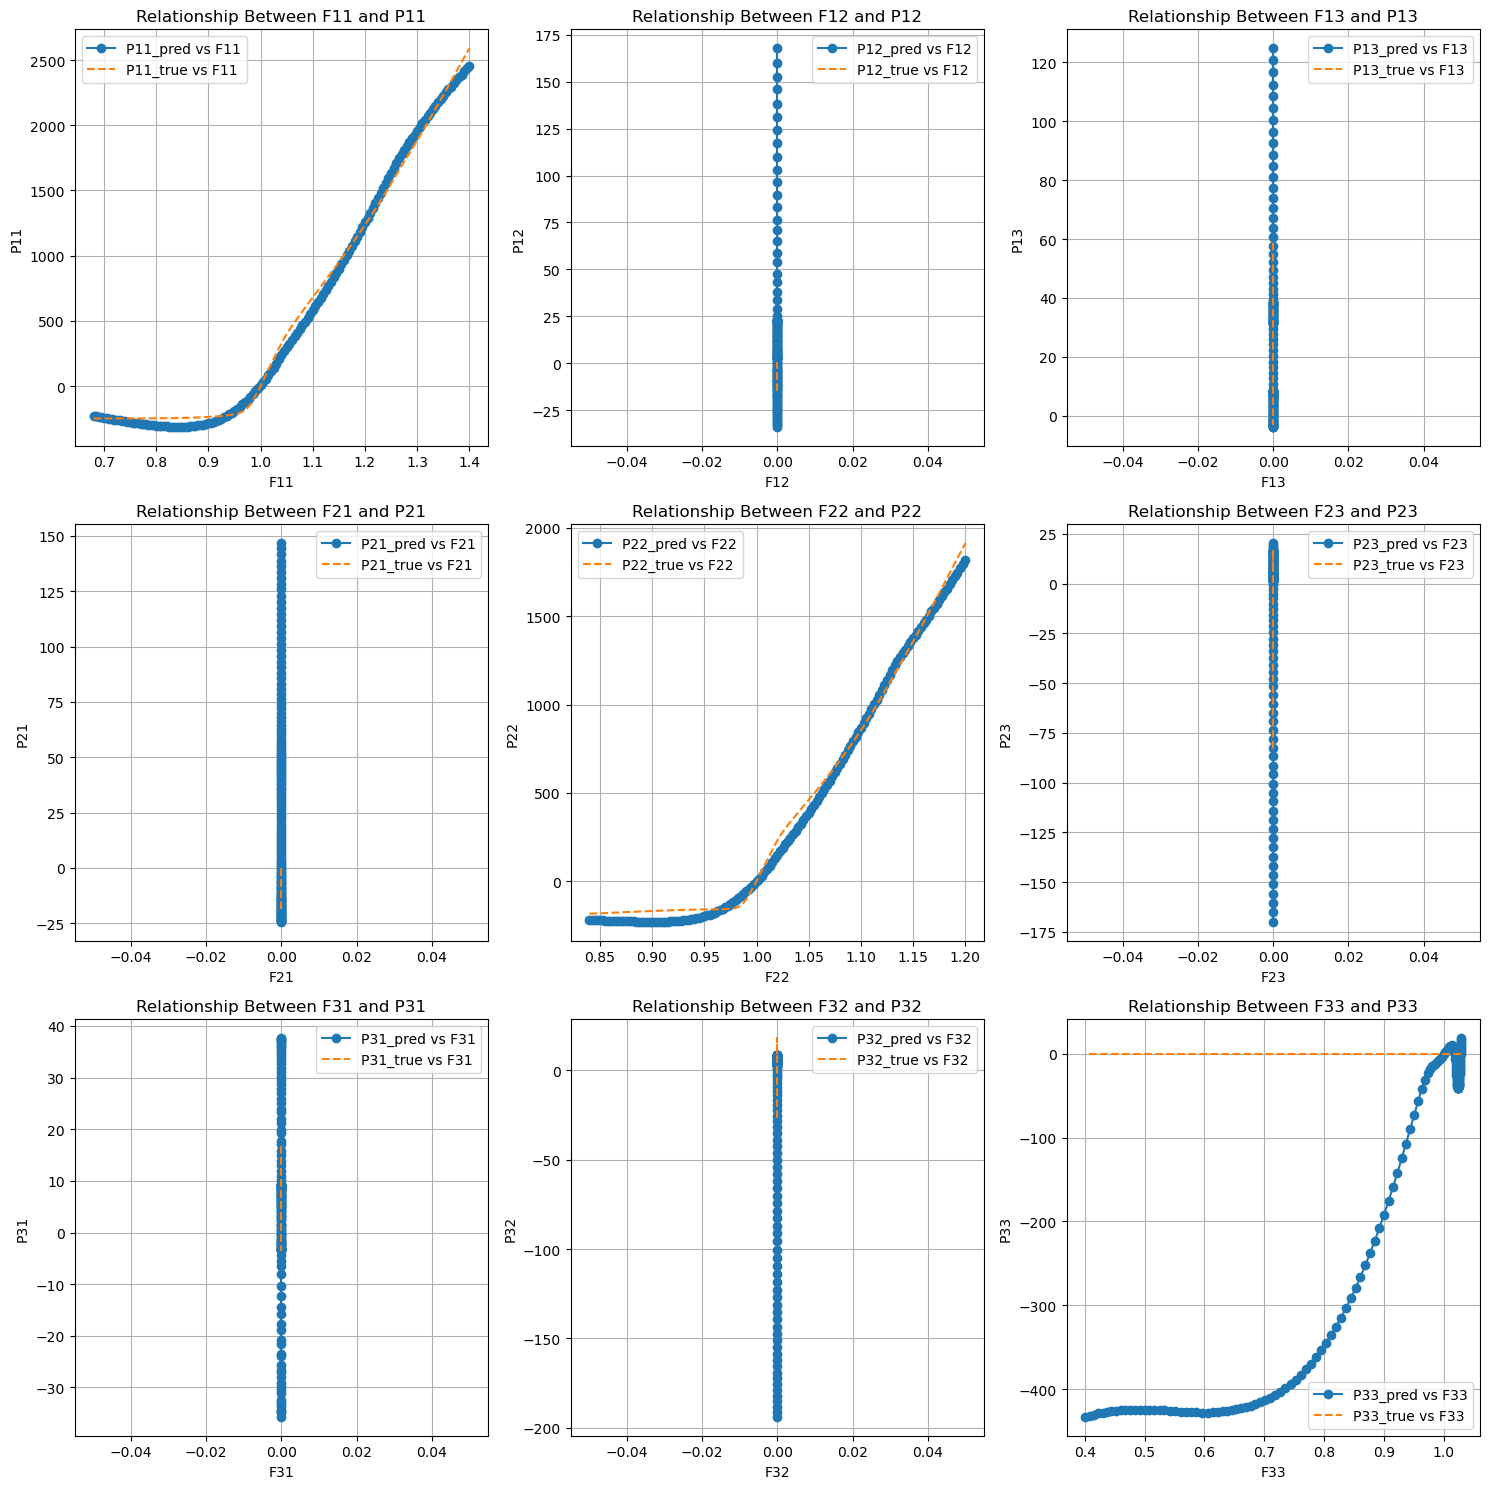

In [86]:
# Extract all components F11 to F33 and P11 to P33
components = ['11', '12', '13', '21', '22', '23', '31', '32', '33']

# Create subplots for each pair of Fij and Pij
plt.figure(figsize=(15, 15))
for i, comp in enumerate(components):
    F_comp = F_test1[:, i // 3, i % 3]  # Extract corresponding F component
    P_pred_comp = P_test_unscaled[:, i // 3, i % 3]  # Predicted P component
    P_true_comp = P_test1[:, i // 3, i % 3]  # True P component

    plt.subplot(3, 3, i + 1)
    plt.plot(F_comp, P_pred_comp, 'o-', label=f'P{comp}_pred vs F{comp}')
    plt.plot(F_comp, P_true_comp, '--', label=f'P{comp}_true vs F{comp}')
    plt.xlabel(f'F{comp}')
    plt.ylabel(f'P{comp}')
    plt.title(f'Relationship Between F{comp} and P{comp}')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()
